# 9.1.22

In [1]:
import glob
import importlib
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import seaborn as sns
from matplotlib import ticker

import extq
import ivac

In [2]:
sys.path.insert(1, "../../python")
import plotting
import util

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [5]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
# parameters mostly taken from original paper
minlag = 10  # 1 ns
maxlag = 1000  # 100 ns
batch_size = 1024
hidden_widths = [8, 8]
patience = 10
n_epochs = 10000

In [7]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy"))
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy"))
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# distances to F161
rf161 = list(np.load(f"{DATA_DIR}/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load(f"{DATA_DIR}/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns lag time
# weights
weights = np.load(
    f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[
    0
]  # 0.1 ns lag time

In [8]:
feature_names = []
feature_names.append("Translocation")
feature_names.append("Rotation")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")
for i in ("R223", "R226", "R229"):
    feature_names.append(f"{i}-F161")

In [9]:
sb_ids = [42, 47, 52, 53, 58, 59]
feat_arr = np.hstack((cv_arr, sb_arr[:, sb_ids], rf161_arr[:, 1:2]))
traj_inds = util.split_indices(cv_trajs)
feat_trajs = np.split(feat_arr, traj_inds)
q_arr = np.concatenate(qp_du)
print(feat_arr.shape, q_arr.shape)

(4150115, 9) (4150115,)


In [10]:
from sklearn.model_selection import train_test_split

In [18]:
# nn_ivac = ivac.NonlinearIVAC(
#     minlag=minlag,
#     maxlag=maxlag,
#     nevecs=3,
#     batch_size=batch_size,
#     val_batch_size=batch_size,
#     val_every=100,
#     hidden_widths=hidden_widths,
#     batchnorm=True,
#     score='VAMP1',
#     patience=patience,
#     maxiter=n_epochs,
#     linear_method='fft'
# )

In [11]:
traj_train, traj_val = train_test_split(feat_trajs, test_size=0.5, random_state=123)

In [12]:
class NonlinearBasis(pl.LightningModule):
    def __init__(
        self,
        nfeatures,
        nbasis,
        hidden_widths=[],
        activation=torch.nn.Tanh,
        batchnorm=False,
        standardize=False,
        score="VAMP1",
        lr=0.001,
    ):
        super().__init__()
        self.lr = lr
        self.hist = {}
        self.hist['train_loss'] = []
        self.hist['val_loss'] = []

        layers = []
        last_features = nfeatures
        for hidden_features in hidden_widths:
            layers.append(torch.nn.Linear(last_features, hidden_features))
            if batchnorm:
                layers.append(torch.nn.BatchNorm1d(hidden_features))
            layers.append(activation())
            last_features = hidden_features
        layers.append(torch.nn.Linear(last_features, nbasis))
        if standardize:
            layers.append(torch.nn.BatchNorm1d(nbasis, affine=False))
        self.model = torch.nn.Sequential(*layers)

        if score == "VAMP1":
            self.score = ivac.nonlinear.VAMPScore(score=1, addones=True)
        elif score == "VAMP2":
            self.score = ivac.nonlinear.VAMPScore(score=2, addones=True)
        else:
            raise ValueError("score must be 'VAMP1' or 'VAMP2'")

    def forward(self, x):
        """Apply the nonlinear combinations to input features."""
        return self.model(x)

    def configure_optimizers(self):
        """Configure the optimizer for training."""
        return torch.optim.AdamW(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        """Compute the training loss."""
        x, y = batch
        xy = torch.cat([x, y])
        xy = self(xy)
        x, y = xy[: len(x)], xy[len(x) :]
        loss = -self.score(x, y)
        self.log("train_loss", loss)
        self.hist['train_loss'].append(loss)
        

    def validation_step(self, batch, batch_idx):
        """Compute the validation loss."""
        x, y = batch
        xy = torch.cat([x, y])
        xy = self(xy)
        x, y = xy[: len(x)], xy[len(x) :]
        loss = -self.score(x, y)
        self.log("val_loss", loss)
        self.hist['val_loss'].append(loss)

In [14]:
def make_dataloader(trajs, batch_size, minlag, maxlag, dtype=torch.float, device='cpu', num_workers=0):
    """Prepare the data for training."""
    dataset = ivac.nonlinear.TimeLaggedPairDataset(
        trajs,
        batch_size,
        minlag,
        maxlag,
        dtype=dtype,
        device=device,
    )
    return torch.utils.data.DataLoader(dataset, batch_size=None, num_workers=num_workers)

In [13]:
model = NonlinearBasis(
    nfeatures=feat_arr.shape[-1], nbasis=2, hidden_widths=hidden_widths, batchnorm=True
)

In [15]:
model

NonlinearBasis(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [16]:
device = "cpu" if torch.cuda.device_count() == 0 else "gpu"

trainer = pl.Trainer(
    accelerator=device,
    # devices=48,
    val_check_interval=1,
    check_val_every_n_epoch=100,
    callbacks=[pl.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=patience)],
    limit_train_batches=1,
    limit_val_batches=1,
    max_epochs=n_epochs,
    log_every_n_steps=1
)

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


In [ ]:
train_dataloader = make_dataloader(traj_train, batch_size, minlag, maxlag, num_workers=48)
val_dataloader = make_dataloader(traj_val, batch_size, minlag, maxlag, num_workers=48)
trainer.fit(model, train_dataloader, val_dataloader)

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 48 worker processes in total. Our suggested max number of worker in current system is 32, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 202   
-------------------------------------
202       Trainable params
0         Non-trainable params
202       Total params
0.001     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:135: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
# plot training and validation loss
plt.plot(model.metrics['train_loss'])
plt.plot(model.metrics['val_loss'])

In [49]:
def transform_basis(model, trajs, dtype=torch.float, device='cpu'):
    """Apply the nonlinear combinations to the input features.

    Parameters
    ----------
    trajs : list of (n_frames[i], n_features) array-like
        List of featurized trajectories.

    Returns
    -------
    list of (n_frames[i], n_evecs - 1) ndarray
        Nonlinear combinations of input features.

    """
    features = []
    for traj in trajs:
        traj = torch.as_tensor(traj, dtype=dtype, device=device)
        features.append(model(traj).detach().cpu().numpy())
    return features

In [50]:
linear = ivac.LinearIVAC(minlag, maxlag, addones=True, method='fft')
linear.fit(transform_basis(model, traj_train))

In [53]:
ivac_trajs = linear.transform(transform_basis(model, feat_trajs))

In [54]:
trainer.logged_metrics

{'train_loss': tensor(-2.7892), 'val_loss': tensor(-2.7901)}

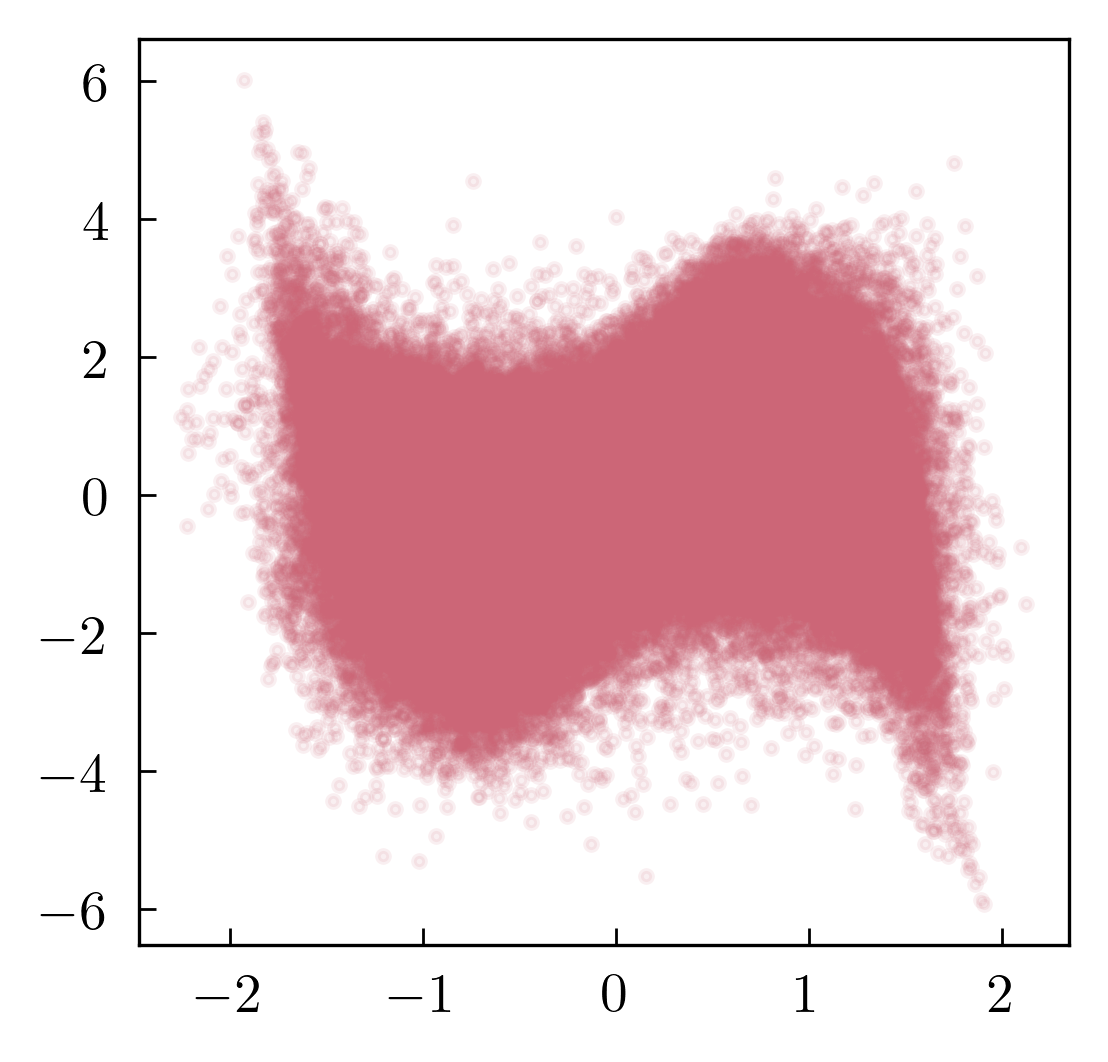

In [55]:
fig = plt.figure(figsize=(3, 3), dpi=200)
ivac_arr = np.concatenate(ivac_trajs)
plt.scatter(ivac_arr[::20, 1], ivac_arr[::20, 2], alpha=0.1)

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


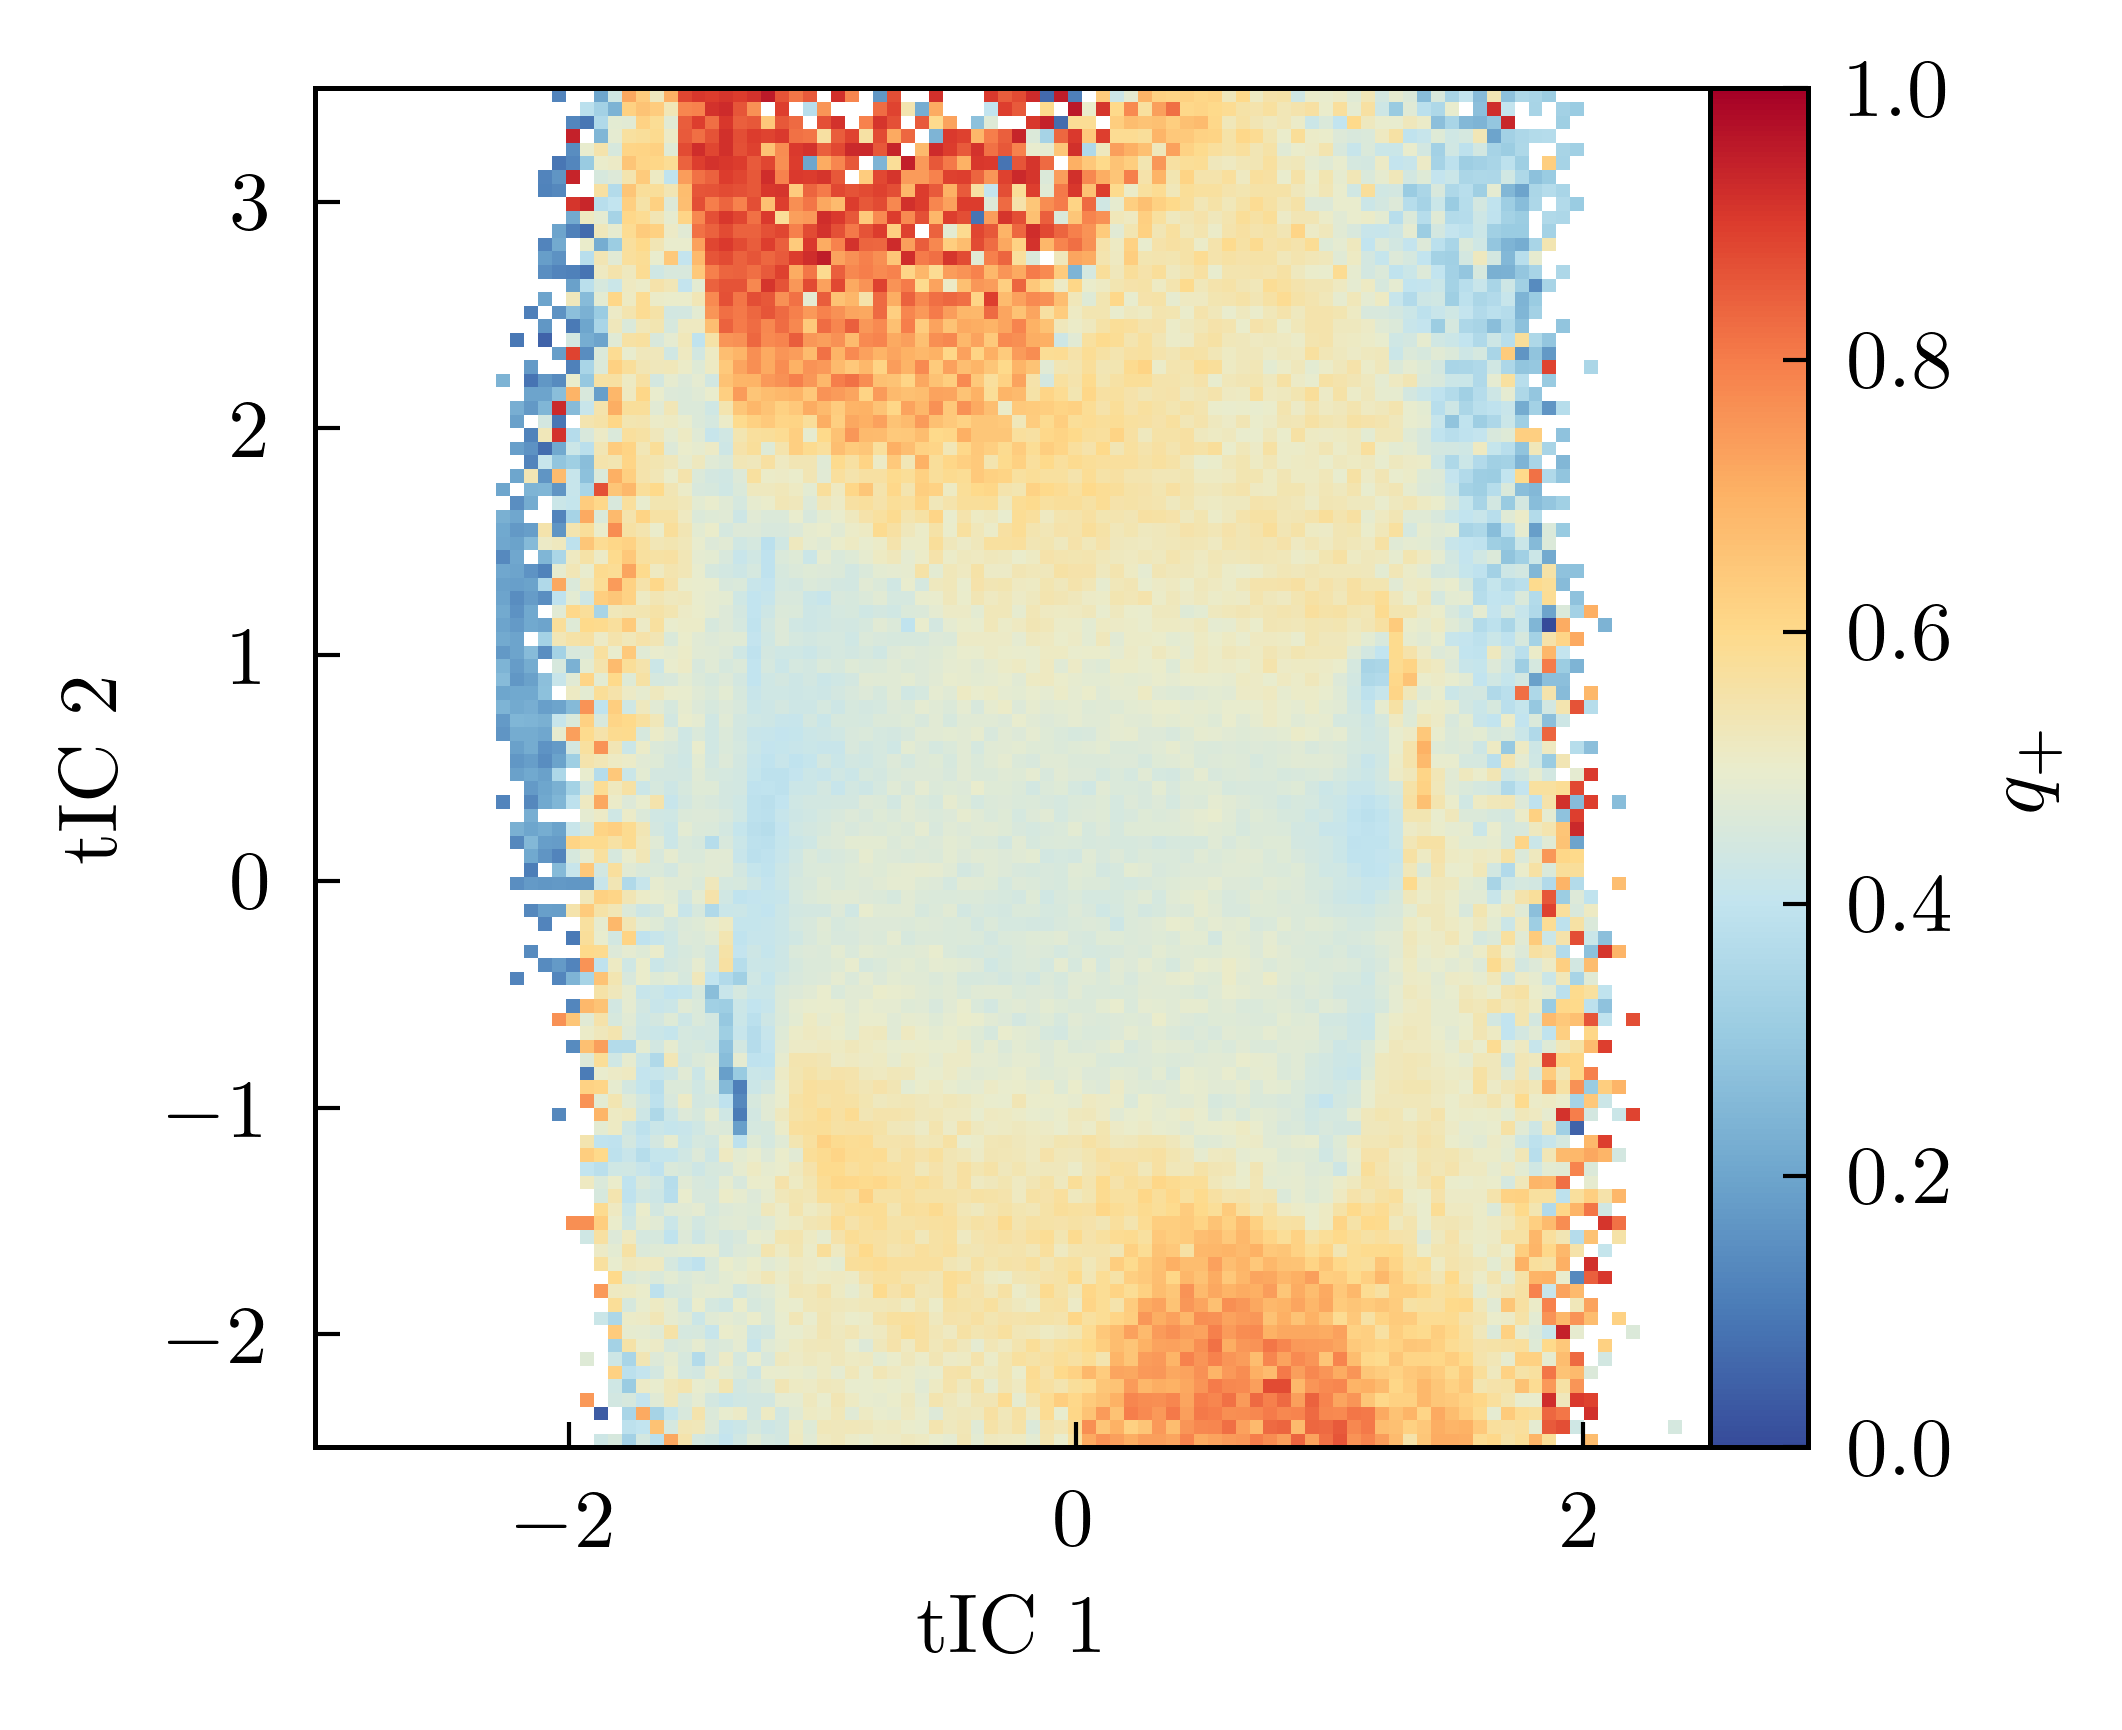

In [56]:
fig = plt.figure(figsize=(3, 3), dpi=300)

ivac_1 = [t[:, 1] for t in ivac_trajs]
ivac_2 = [t[:, 2] for t in ivac_trajs]
xe = np.linspace(-3, 2.5, 101)
ye = np.linspace(-2.5, 3.5, 101)
q_avg = extq.projection.average2d(ivac_1, ivac_2, qp_du, weights, xe, ye)
pc = plt.pcolormesh(xe, ye, q_avg.T, cmap='diverging', vmin=0, vmax=1)
ax = plt.gca()
# plotting.plot_models(ax, ivac_models[:, 1:3], ms=6)
plt.xlabel("tIC 1")
plt.ylabel("tIC 2")
pplt.colorbar(pc, label="$q_+$")